## Importing libraries

In [1]:
import numpy as np
import pyemma
import matplotlib.pyplot as plt
%matplotlib inline
import MDAnalysis as md
from MDAnalysis.analysis.rms import rmsd
from MDAnalysis.analysis import align
from shapeGMM import gmm_shapes
import os
import sys
import pickle
import glob
from matplotlib.collections import LineCollection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

/ext3/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read Trajectory and select backbone atoms 

In [2]:
# read trajectory data
data_path = '/scratch/work/hockygroup/gmh4/projects/gmm_clustering/data/DESRES-Trajectory_pnas2012-2f4k-360K-protein/pnas2012-2f4k-360K-protein/'
backbone_selection_101 = "(name C and resid 42) or (name C CA N and not resid 42 76) or (name N and resid 76)"
# LOAD DATA
prmtopFileName =  data_path + 'pnas2012-2f4k-360K-protein.pdb'
# make an ordered list of all the files
trajFiles = sorted(glob.glob(data_path+"*.dcd"))
#print(trajFiles)
#print(len(trajFiles))
coord = md.Universe(prmtopFileName,trajFiles)
sel_backbone_101 = coord.select_atoms(backbone_selection_101)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:",coord.trajectory.n_frames)
print("Number of atoms being analyzed:",sel_backbone_101.n_atoms)
print("Number of frames being analyzed:",coord.trajectory.n_frames)
trajData = np.empty((coord.trajectory.n_frames,sel_backbone_101.n_atoms,3),dtype=float)
count = 0
for ts in coord.trajectory:
    trajData[count,:,:] = sel_backbone_101.positions - sel_backbone_101.center_of_geometry()
    count += 1

Number of atoms in trajectory: 577
Number of frames in trajectory: 1526041
Number of atoms being analyzed: 101
Number of frames being analyzed: 1526041


In [3]:
print(trajData.shape)

(1526041, 101, 3)


## load clustered objects

In [4]:
# load the object
with open("/scratch/projects/hockygroup/ss12902/hp35_sGMM/hp35_wsgmm_6_clusters_reorderd.pickle", "rb")as f_o:
    wsgmm = pickle.load(f_o)

# load cluster assignments
clusters = np.loadtxt("/scratch/projects/hockygroup/ss12902/hp35_sGMM/hp35_wsgmm_6_clusters_reorderd_full_traj.clusters")
print(clusters.shape)

print("Train log likelihood per frame :", wsgmm.log_likelihood/wsgmm.n_frames)

(1526041,)
Train log likelihood per frame : 379.8134702799295


In [5]:
cluster_ids, cluster_populations = np.unique(clusters,return_counts=True)
n_clusters = cluster_ids.size

print("Total no. of clusters =", n_clusters)
print("Cluster ID:", cluster_ids)
print("Populations of clusters:", cluster_populations)

Total no. of clusters = 6
Cluster ID: [0. 1. 2. 3. 4. 5.]
Populations of clusters: [513969 326358 203663 167295 157838 156918]


## Choosing the folded and unfolded states

1. We will consider the most populated state as native or folded state and least populated state as unfolded state.
2. According to the population data shown above, cluster-id=0 is folded while cluster-id= 4 or 5 corresponds to unfolded state.

In [6]:
# extracting out frames belonging to different clusters

folded_frames = trajData[[x[0] for x in np.argwhere(clusters == 0)]]
print(folded_frames.shape)

c4_frames = trajData[[x[0] for x in np.argwhere(clusters == 4)]]
print(c4_frames.shape)

c5_frames = trajData[[x[0] for x in np.argwhere(clusters == 5)]]
print(c5_frames.shape)

(513969, 101, 3)
(157838, 101, 3)
(156918, 101, 3)


## Load aligned trajs 

In [7]:
# assign 0 to unfolded frames and 1 to folded frames
f_c = np.ones(folded_frames.shape[0])
u_c = np.zeros(c4_frames.shape[0])

clusters_assigned = np.concatenate([f_c, u_c], axis=0)

print(clusters_assigned.shape)
#print(clusters_assigned[-1:-50:-1])

(671807,)


In [8]:
# loading the aligned trajs
folded_aligned_traj = np.load("/scratch/projects/hockygroup/ss12902/hp35_sGMM/folded_aligned_traj.npy", allow_pickle=True)
unfolded_aligned_traj = np.load("/scratch/projects/hockygroup/ss12902/hp35_sGMM/unfolded_aligned_traj.npy", allow_pickle=True)
global_aligned_traj = np.load("/scratch/projects/hockygroup/ss12902/hp35_sGMM/global_aligned_traj.npy", allow_pickle=True)

print(global_aligned_traj.shape)
print(folded_aligned_traj.shape)
print(unfolded_aligned_traj.shape)

(1526041, 101, 3)
(1526041, 101, 3)
(1526041, 101, 3)


In [9]:
folded_aligned_traj_frames = np.concatenate([folded_aligned_traj[[x[0] for x in np.argwhere(clusters == 0)]],\
                                             folded_aligned_traj[[x[0] for x in np.argwhere(clusters == 4)]]], axis=0)


unfolded_aligned_traj_frames = np.concatenate([unfolded_aligned_traj[[x[0] for x in np.argwhere(clusters == 0)]],\
                                             unfolded_aligned_traj[[x[0] for x in np.argwhere(clusters == 4)]]], axis=0)


global_aligned_traj_frames = np.concatenate([global_aligned_traj[[x[0] for x in np.argwhere(clusters == 0)]],\
                                             global_aligned_traj[[x[0] for x in np.argwhere(clusters == 4)]]], axis=0)

In [10]:
print(folded_aligned_traj_frames.shape)
print(global_aligned_traj_frames.shape)

(671807, 101, 3)
(671807, 101, 3)


## compute committor

In [11]:
# setting the traj labels for each frame
traj_labels = np.zeros(coord.trajectory.n_frames)
print(traj_labels.shape)

for i in range(len(traj_labels)):
    
    # folded state
    if clusters[i] == 0:
        
        # assign 1 to folded state
        traj_labels[i] = 1
        
    # unfolded state
    elif clusters[i] == 4:
        
        # assign 0 to unfolded state
        traj_labels[i] = 0
    
    else:
        
        # assign 2 to any other frames
        traj_labels[i] = 2

print(np.unique(traj_labels))
# save the traj labels
np.savetxt('traj_labels.txt', traj_labels, fmt="%1.1f")

(1526041,)
[0. 1. 2.]


1526041


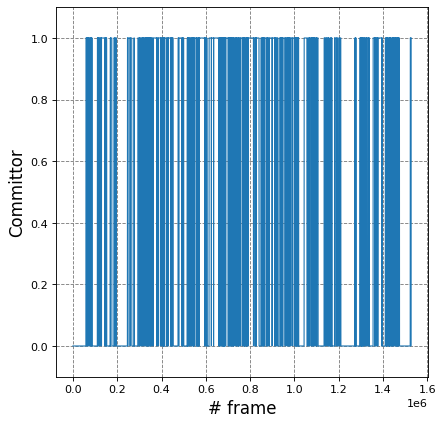

In [12]:
import compute_committor_modf
import importlib
importlib.reload(compute_committor_modf)
comm = compute_committor_modf.b_before_a(traj_labels,state_a=0,state_b=1)
print(len(comm))
#print(comm[:30])

#save the committor 
np.savetxt('comm.dat', comm, fmt="%1.1f")

# make a plot for committor
plt.figure(figsize=(6,6), dpi=80)
# no -ve values are presesnt in committor data (good point!) 
#plt.plot(comm, '.') 
plt.plot(comm, lw=1.0) 
plt.ylim(-0.1, 1.1)
plt.xlabel("# frame", fontsize=15)
plt.ylabel("Committor", fontsize=15)
plt.grid(b=True, which='major', axis='both', color='#808080', linestyle="--")

## 2. FE vs. LD1 (computed from 310us DESRES data)

command line: plumed kt --temp 360.0 --units kcal/mol

When the temperature is 360.000000 kelvin kT is equal to 0.715393 kcal/mol (From PLUMED)

In [13]:
kbt = 0.715393 # in kcal/mol unit at 360.0K

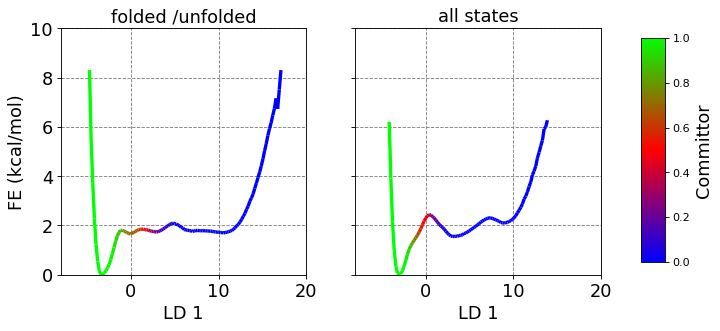

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True, dpi=80)

# ================================ #
# folded and unfolded frames only  #
# ================================ #

ld_range = (-8,20)
nbins=150
cmap = 'brg'

axs[0].set_title("folded /unfolded", fontsize=16)
axs[0].set_ylabel("FE (kcal/mol)",fontsize=16)
axs[0].set_xlabel("LD 1", fontsize=16)
axs[0].tick_params(axis='both',labelsize=16)
axs[0].grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
# set lims
axs[0].set_xlim(-8,20)
axs[0].set_ylim(0.0, 10.0)

# lda calculation
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda.fit(global_aligned_traj_frames.reshape(global_aligned_traj_frames.shape[0], sel_backbone_101.n_atoms*3), clusters_assigned)
ld1_fu = lda.transform(global_aligned_traj.reshape(global_aligned_traj.shape[0], sel_backbone_101.n_atoms*3))[:,0]
ld1_fu *= -1.0

# histogram 
hist, bins = np.histogram(ld1_fu, range=ld_range, bins=nbins, density=True)
fe = -kbt*np.log(hist)
grids = (bins[:-1] + bins[1:])/2

dx = bins[1]-bins[0]
comm_average_var = []
for my_bin in bins:
    sgmm_idx = np.where( (ld1_fu[1::] >=my_bin) * (ld1_fu[1::] <my_bin+dx) )[0]
    comm_average_var.append([comm[sgmm_idx].mean(),comm[sgmm_idx].var()])
comm_average_var = np.array(comm_average_var)

# create the segments
points = np.array([grids, fe-fe.min()]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a continuous norm to map from data points to colors
#norm1 = plt.Normalize(comm_average_var[:,0].min(), comm_average_var[:,0].max())
norm1 = plt.Normalize(0.0, 1.0)  # setting the limit [0,1]
lc = LineCollection(segments, cmap=cmap, norm=norm1)

# Set the values used for colormapping
lc.set_array(comm_average_var[:,0])
lc.set_linewidth(3)
line = axs[0].add_collection(lc)
#cbar = fig.colorbar(line, ax=axs[0])
#cbar.set_label("avg. committor", fontsize=16)


# ================================ #
#        using all frames only     #
# ================================ #

ld_range = (-5,14)
nbins=100
cmap = 'brg'

axs[1].set_title("all states", fontsize=16)
#axs[1].set_ylabel("FE (kcal/mol)",fontsize=16)
axs[1].set_xlabel("LD 1", fontsize=16)
axs[1].tick_params(axis='both',labelsize=16)
axs[1].grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
# set lims
#axs[1].set_xlim(-5,14)
axs[1].set_xlim(-8,20)
axs[1].set_ylim(0.0, 10.0)

# lda calculation
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
ld1 = lda.fit_transform(global_aligned_traj.reshape(global_aligned_traj.shape[0], sel_backbone_101.n_atoms*3), clusters)[:,0]

# histogram 
hist, bins = np.histogram(ld1, range=ld_range, bins=nbins, density=True)
fe = -kbt*np.log(hist)
grids = (bins[:-1] + bins[1:])/2

dx = bins[1]-bins[0]
comm_average_var = []
for my_bin in bins:
    sgmm_idx = np.where( (ld1[1::] >=my_bin) * (ld1[1::] <my_bin+dx) )[0]
    comm_average_var.append([comm[sgmm_idx].mean(),comm[sgmm_idx].var()])
comm_average_var = np.array(comm_average_var)

# create the segments
points = np.array([grids, fe-fe.min()]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a continuous norm to map from data points to colors
#norm1 = plt.Normalize(comm_average_var[:,0].min(), comm_average_var[:,0].max())
norm1 = plt.Normalize(0.0, 1.0)  # setting the limit [0,1]
lc = LineCollection(segments, cmap=cmap, norm=norm1)

# Set the values used for colormapping
lc.set_array(comm_average_var[:,0])
lc.set_linewidth(3)
line = axs[1].add_collection(lc)
#cbar = fig.colorbar(line, ax=axs[1])
#cbar.set_label("avg. committor", fontsize=16)



#=========================================================================================#
# this part is for putting a common colorbar for all the subplots
fig.subplots_adjust(right=0.8)  # size of the figure
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7]) # dimesnion of the colorbar.
#cbar_ax = fig.add_axes([0.85, 0.30, 0.05, 0.45]) # dimesnion of the colorbar.
cbar = fig.colorbar(line, cax=cbar_ax)
cbar.set_label("Committor", fontsize=16)
#plt.clim(0,1)

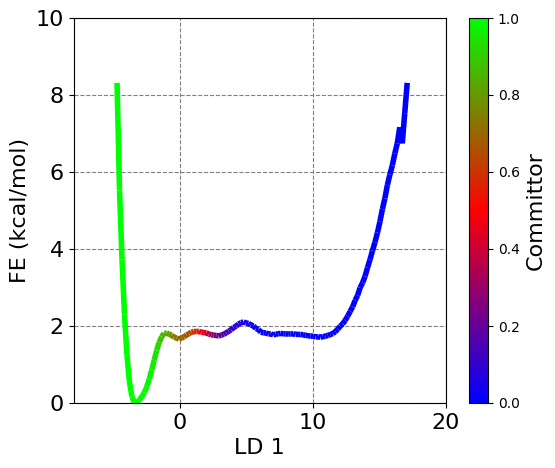

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(6,5), dpi=100)

# ================================ #
# folded and unfolded frames only  #
# ================================ #

ld_range = (-8,20)
nbins=150
cmap = 'brg'

#axs.set_title("folded /unfolded", fontsize=16)
axs.set_ylabel("FE (kcal/mol)",fontsize=16)
axs.set_xlabel("LD 1", fontsize=16)
axs.tick_params(axis='both',labelsize=16)
axs.grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
# set lims
axs.set_xlim(-8,20)
axs.set_ylim(0.0, 10.0)

# lda calculation
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda.fit(global_aligned_traj_frames.reshape(global_aligned_traj_frames.shape[0], sel_backbone_101.n_atoms*3), clusters_assigned)
ld1_fu = lda.transform(global_aligned_traj.reshape(global_aligned_traj.shape[0], sel_backbone_101.n_atoms*3))[:,0]
ld1_fu *= -1.0

# histogram 
hist, bins = np.histogram(ld1_fu, range=ld_range, bins=nbins, density=True)
fe = -kbt*np.log(hist)
grids = (bins[:-1] + bins[1:])/2

dx = bins[1]-bins[0]
comm_average_var = []
for my_bin in bins:
    sgmm_idx = np.where( (ld1_fu[1::] >=my_bin) * (ld1_fu[1::] <my_bin+dx) )[0]
    comm_average_var.append([comm[sgmm_idx].mean(),comm[sgmm_idx].var()])
comm_average_var = np.array(comm_average_var)

# create the segments
points = np.array([grids, fe-fe.min()]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a continuous norm to map from data points to colors
#norm1 = plt.Normalize(comm_average_var[:,0].min(), comm_average_var[:,0].max())
norm1 = plt.Normalize(0.0, 1.0)  # setting the limit [0,1]
lc = LineCollection(segments, cmap=cmap, norm=norm1)

# Set the values used for colormapping
lc.set_array(comm_average_var[:,0])
lc.set_linewidth(4)
line = axs.add_collection(lc)
cbar = fig.colorbar(line, ax=axs)
cbar.set_label("Committor", fontsize=16)

# save 
plt.savefig("fe_vs_ld1_folded_unfolded_colored_comm.pdf", format="pdf")

## Histograms of LD1 vectors for different clusters

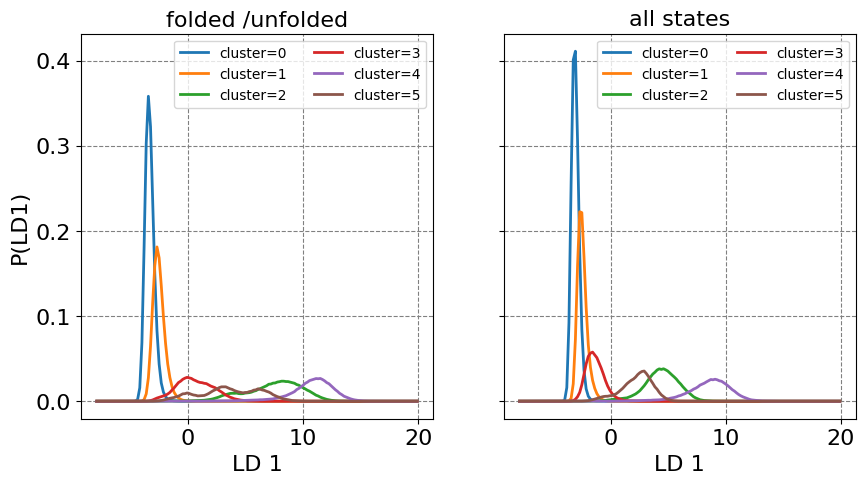

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True, dpi=100)

# ================================ #
# folded and unfolded frames only  #
# ================================ #

ld_range = (-8,20)
nbins=150

axs[0].set_title("folded /unfolded", fontsize=16)
axs[0].set_ylabel("P(LD1)",fontsize=16)
axs[0].set_xlabel("LD 1", fontsize=16)
axs[0].tick_params(axis='both',labelsize=16)
axs[0].grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
# set lims
#axs[0].set_xlim(-8,20)
#axs[0].set_ylim(0.0, 10.0)

# looping over clusters
for i in range(n_clusters):
    
    # extracting LD values corresponding to each state
    ld_i = ld1_fu[[x[0] for x in np.argwhere(clusters == i)]]
    
    # histogramming
    hist_i ,bins = np.histogram(ld_i, range=ld_range, bins=nbins, density=True)
    grids = (bins[1:] + bins[:-1])/2.0
    
    # calculate the weights
    weight = np.argwhere(clusters==i).size/clusters.size
    
    #plot it
    axs[0].plot(grids, hist_i*weight, label="cluster=%d"%i, lw=2.0)
    #axs[0].plot(grids, hist_i, label="cluster=%d"%i, lw=2.0)    
    #axes[0].fill_between(grids, hist_i)
axs[0].legend(loc="upper right", ncol=2, fontsize="medium", markerscale=2.0)


# ================================ #
#        using all frames only     #
# ================================ #

axs[1].set_title("all states", fontsize=16)
axs[1].set_xlabel("LD 1", fontsize=16)
axs[1].tick_params(axis='both',labelsize=16)
axs[1].grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
# set lims
#axs[1].set_xlim(-5,14)
#axs[1].set_xlim(-8,20)
#axs[1].set_ylim(0.0, 10.0)

# looping over clusters
for i in range(n_clusters):
    
    # extracting LD values corresponding to each state
    ld_i = ld1[[x[0] for x in np.argwhere(clusters == i)]]
    
    # histogramming
    hist_i ,bins = np.histogram(ld_i, range=ld_range, bins=nbins, density=True)
    grids = (bins[1:] + bins[:-1])/2.0
    
    # calculate the weights
    weight = np.argwhere(clusters==i).size/clusters.size
    
    #plot it
    axs[1].plot(grids, hist_i*weight, label="cluster=%d"%i, lw=2.0)
    #axs[1].plot(grids, hist_i, label="cluster=%d"%i, lw=2.0)    
    #axes[1].fill_between(grids, hist_i)
axs[1].legend(loc="upper right", ncol=2, fontsize="medium", markerscale=2.0)

In [17]:
grids_desres = grids.copy()
fe_desres = fe-fe.min().copy()

## 1. Probability of LD1 (folded/ unfolded) from DESRES

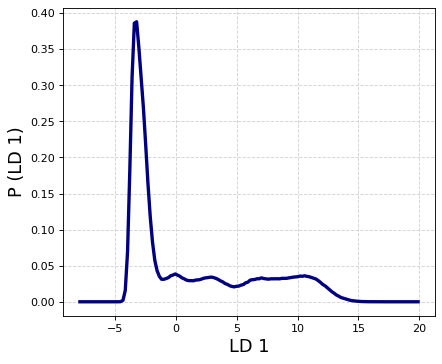

In [18]:
plt.figure(figsize=(6,5), dpi=80)
plt.xlabel("LD 1", fontsize=16)
plt.ylabel("P (LD 1)", fontsize=16)
plt.grid(axis="both", which="major", linestyle="--", color="lightgrey")
plt.plot(grids, hist, lw=3.0, color="navy")

# save
plt.savefig("prob_ld1_folded_unfolded.pdf")

In [19]:
def kabsch_rotate(mobile, ref):
    correlation = np.dot(mobile.T,ref)
    v, s, w_tr = np.linalg.svd(correlation)
    # enforce determinant of rotation matrix is 1 (not negative 1)
    if np.linalg.det(v) * np.linalg.det(w_tr) < 0.0:
        v[:,-1] *= -1
    rotation = np.dot(v, w_tr)
    #print(rotation)
    # rotate
    return np.dot(mobile,rotation)

def project_trajectory_lda_weighted(trajectory, ref, precision, lda_vector):
    # meta data
    n_frames = trajectory.shape[0]
    n_atoms = trajectory.shape[1]
    # check everything else has matching size
    assert ref.shape[0] == n_atoms, "Atom numbers different in trajectory and reference"
    assert precision.shape[0] == n_atoms, "Atom numbers different in trajectory and precision"
    assert lda_vector.shape[0] == n_atoms*3, "LDA vector dimension do not match trajectory"
    # declare arrays
    projections = np.empty(n_frames,dtype=np.float64)
    # loop over trajectory
    weighted_ref = np.dot(precision, ref)
    for frame in range(n_frames):
        disp = (kabsch_rotate(trajectory[frame],weighted_ref) - ref).flatten()
        #disp = kabsch_rotate(trajectory[frame],weighted_ref).flatten()    # not using displacement
        #disp = -(kabsch_rotate(trajectory[frame],weighted_ref) - ref).flatten()   # tested with -ve sign
        projections[frame] = np.dot(disp,lda_vector)
    return projections

In [20]:
# load important data 
fu_avg = np.loadtxt("/scratch/projects/hockygroup/ss12902/hp35_sGMM/fu_avg.txt")
fu_precision = np.loadtxt("/scratch/projects/hockygroup/ss12902/hp35_sGMM/fu_precision.txt")
ref_ = np.loadtxt("/scratch/projects/hockygroup/ss12902/hp35_sGMM/global_avg.txt")
prec_ = np.loadtxt("/scratch/projects/hockygroup/ss12902/hp35_sGMM/global_precision.txt")
vec_ = np.loadtxt("/scratch/projects/hockygroup/ss12902/hp35_sGMM/lda_scalings_global_folded_unfolded_ld1.txt")

In [21]:
proj_fu_avg = project_trajectory_lda_weighted(fu_avg.reshape(1,fu_avg.shape[0],\
                                                             fu_avg.shape[1]), ref_, prec_, vec_)
print(proj_fu_avg)

[0.89930418]


In [49]:
# load OPES_MEATD data
time, ld1_opes, opes_bias = np.loadtxt("/scratch/projects/hockygroup/ss12902/opes_metad_folded_unfolded_ld1_360K/COLVAR", usecols=(0,1,2), unpack=True)
time *= 1e-3
ld1_opes *= -1

In [50]:
print(opes_bias.shape)

(2500005,)


In [23]:
ld_desres = np.loadtxt("/scratch/projects/hockygroup/ss12902/test_lda_from_desres/COLVAR", usecols=2, dtype=float)*-1

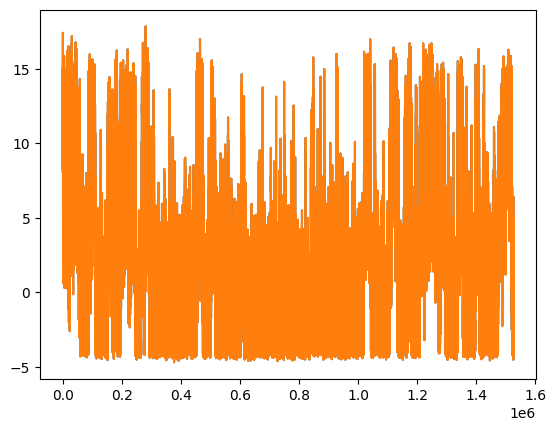

In [24]:
plt.plot(ld_desres+proj_fu_avg)
#plt.plot(ld_desres+0.71441794)
plt.plot(ld1_fu)

## 4a. LD1 vs. time for DESRES and OPES_METAD

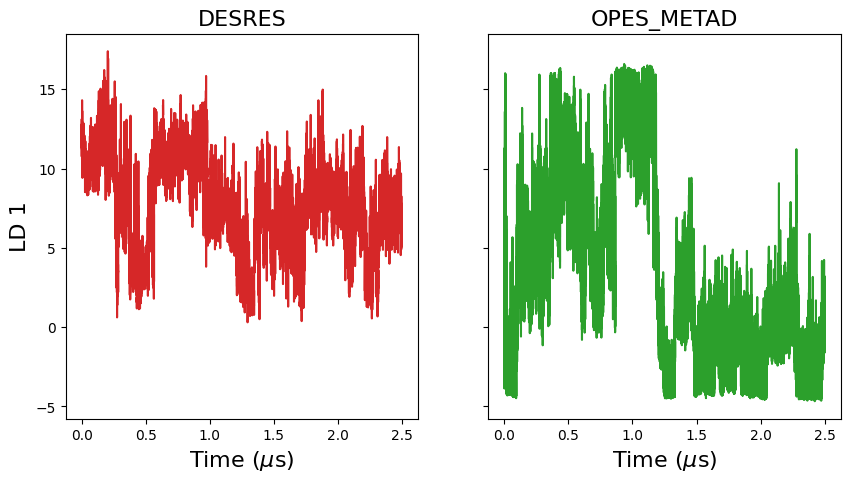

In [25]:
fig, axs= plt.subplots(1, 2, sharey=True, figsize=(10,5), dpi=100)

axs[0].set_xlabel("Time ($\\mu$s)", fontsize=16)
axs[0].set_ylabel("LD 1", fontsize=16)
axs[0].set_title("DESRES", fontsize=16)
axs[0].plot((np.arange(trajData.shape[0])*200.0*1e-6)[:12510:], ld1_fu[:12510:], color="tab:red")


axs[1].set_xlabel("Time ($\\mu$s)", fontsize=16)
axs[1].set_title("OPES_METAD", fontsize=16)
axs[1].plot(time*1e-3, ld1_opes+proj_fu_avg, color="tab:green")

plt.savefig("ld1_vs_time_compare.pdf", format="pdf")

In [66]:
# load OPES_METAD data from 10us long extended run
time, ld1_opes, opes_bias = np.loadtxt("/scratch/projects/hockygroup/ss12902/opes_metad_folded_unfolded_ld1_360K/extended_data_from_glen/COLVAR", usecols=(0,1,2), unpack=True)
time *= 1e-3
ld1_opes *= -1

print(opes_bias.shape)

(10474936,)


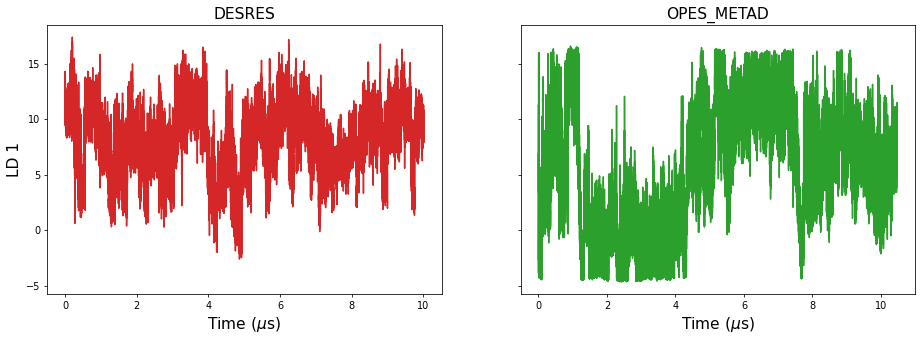

In [27]:
# =========================================================== #
# try the same plot with 10us long OPES_METAD simulation data #
# =========================================================== #

fig, axs= plt.subplots(1, 2, sharey=True, figsize=(16,5), dpi=70)

axs[0].set_xlabel("Time ($\\mu$s)", fontsize=16)
axs[0].set_ylabel("LD 1", fontsize=16)
axs[0].set_title("DESRES", fontsize=16)
axs[0].plot((np.arange(trajData.shape[0])*200.0*1e-6)[:50040:], ld1_fu[:50040:], color="tab:red")


axs[1].set_xlabel("Time ($\\mu$s)", fontsize=16)
axs[1].set_title("OPES_METAD", fontsize=16)
axs[1].plot(time*1e-3, ld1_opes+proj_fu_avg, color="tab:green")

In [28]:
def radgyr(atomgroup, masses, total_mass=None):
    # coordinates change for each frame
    coordinates = atomgroup.positions
    center_of_mass = atomgroup.center_of_mass()

    # get squared distance from center
    ri_sq = (coordinates-center_of_mass)**2
    # sum the unweighted positions
    sq = np.sum(ri_sq, axis=1)
    sq_x = np.sum(ri_sq[:,[1,2]], axis=1) # sum over y and z
    sq_y = np.sum(ri_sq[:,[0,2]], axis=1) # sum over x and z
    sq_z = np.sum(ri_sq[:,[0,1]], axis=1) # sum over x and y

    # make into array
    sq_rs = np.array([sq, sq_x, sq_y, sq_z])

    # weight positions
    rog_sq = np.sum(masses*sq_rs, axis=1)/total_mass
    # square root and return
    return np.sqrt(rog_sq)

In [29]:
rog_desres = np.load("/scratch/projects/hockygroup/ss12902/hp35_sGMM/rog-data.npy", allow_pickle=True)
print(rog_desres.shape)
#plt.plot(rog_desres[:,0])

(1526041, 4)


In [30]:
#coord_new = md.Universe("/scratch/projects/hockygroup/ss12902/opes_metad_folded_unfolded_ld1_360K/analysis/npt.gro",\
#                        "/scratch/projects/hockygroup/ss12902/opes_metad_folded_unfolded_ld1_360K/analysis/opes_metad_ld1_hp35_360K_bf_8.0_barrier_10.0_wrapped.xtc")

coord_new = md.Universe("/scratch/projects/hockygroup/ss12902/opes_metad_folded_unfolded_ld1_360K/analysis/npt.gro",\
                        "/scratch/projects/hockygroup/gmh4/projects/gmm_clustering/subarna_simulations/opes_metad_folded_unfolded_ld1_360K/run_3/analysis/opes_metad_ld1_hp35_360K_bf_8.0_barrier_10.0_wrapped.xtc")


bb_atoms = "(name C and resid 1) or (name C CA N and not resid 1 35) or (name N and resid 35)"
sel_atoms = coord_new.select_atoms(bb_atoms)

#print(sel_atoms.indices)
#print(len(sel_atoms))

In [34]:
opes_traj = np.load("opes_traj.npy", allow_pickle=True)
print(opes_traj.shape)

(209369, 101, 3)


In [44]:
from MDAnalysis.analysis.base import (AnalysisBase,AnalysisFromFunction,analysis_class)

# calculate the radius of gyration for entore trajectory
rog = AnalysisFromFunction(radgyr, coord_new.trajectory, sel_atoms, sel_atoms.masses, total_mass=np.sum(sel_atoms.masses))
rog.run()

In [45]:
rog_metad = rog.results.timeseries

#np.save("rog_metad_opes.npy", rog_metad, allow_pickle=True)
np.save("rog_metad_opes_10us.npy", rog_metad, allow_pickle=True)

print(rog_metad.shape)

(209369, 4)


## 4b. $R_{g}$ vs. time plot for DESRES and OPES_METAD

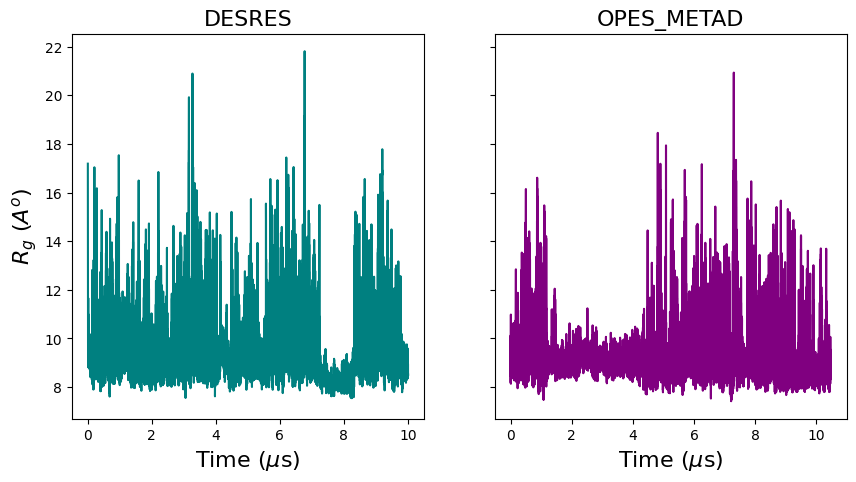

In [46]:
fig, axs = plt.subplots(1,2, sharey=True, figsize=(10,5), dpi=100)

axs[0].set_xlabel("Time ($\\mu$s)", fontsize=16)
axs[0].set_ylabel("$R_g$ ($A^o$)", fontsize=16)
axs[0].set_title("DESRES", fontsize=16)

#axs[0].plot((np.arange(trajData.shape[0])*200.0*1e-6)[:12510:], rog_desres[:,0][:12510:], color="teal")
axs[0].plot((np.arange(trajData.shape[0])*200.0*1e-6)[:50040:], rog_desres[:,0][:50040:], color="teal")



axs[1].set_xlabel("Time ($\\mu$s)", fontsize=16)
axs[1].set_title("OPES_METAD", fontsize=16)
axs[1].plot(np.arange(rog_metad.shape[0])*50*1e-6, rog_metad[:,0], color="purple")

plt.savefig("rg_vs_time_compare.pdf", format="pdf")

## 5. FE vs. LD1 for DESRES and OPES_METAD 

In [35]:
# load data (Used the same range and nbins as DESRES!)
x, fx = np.loadtxt("/scratch/projects/hockygroup/ss12902/opes_metad_folded_unfolded_ld1_360K/analysis/fe_ld1_state.dat", usecols=(0,1), unpack=True)
x *= -1.0    # change sign 
fx /= 4.184  # convert to kcal/mol
gamma = 8    # gamma/BF = T+delT/T;

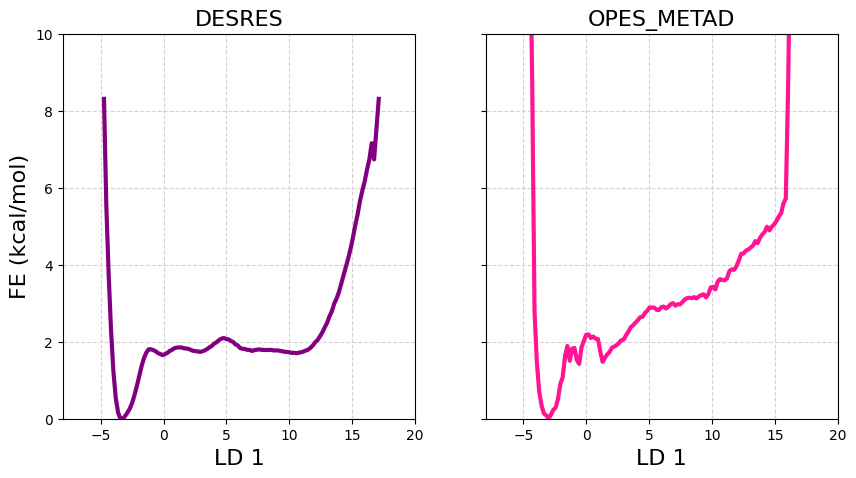

In [36]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10,5), dpi=100)

axs[0].set_xlim(-8,20)
axs[0].set_ylim(0,10)
axs[0].set_xlabel("LD 1", fontsize=16)
axs[0].set_ylabel("FE (kcal/mol)", fontsize=16)
axs[0].set_title("DESRES", fontsize=16)
axs[0].grid(axis="both", which="major", linestyle="--", color="lightgrey")
axs[0].plot(grids, fe-fe.min(), lw=3.0, color="purple")


axs[1].set_xlim(-8,20)
axs[1].set_ylim(0,10)
axs[1].set_xlabel("LD 1", fontsize=16)
axs[1].set_title("OPES_METAD", fontsize=16)
axs[1].grid(axis="both", which="major", linestyle="--", color="lightgrey")

#axs[1].plot(x+proj_fu_avg, fx*(gamma/(gamma-1)), lw=3.0, color="deeppink")  ### need to check the pre factor thing!!
axs[1].plot(x+proj_fu_avg, fx, lw=3.0, color="deeppink")  ### need to check the pre factor thing!!

# save
plt.savefig("fe_vs_ld1_compare.pdf", format="pdf")

In [37]:
# load data (Used the same range and nbins as DESRES!)
x, fx = np.loadtxt("/scratch/projects/hockygroup/ss12902/opes_metad_folded_unfolded_ld1_360K/extended_data_from_glen/analysis/fe_ld1_state.dat", usecols=(0,1), unpack=True)
x *= -1.0    # change sign 
fx /= 4.184  # convert to kcal/mol
gamma = 8    # gamma/BF = T+delT/T;

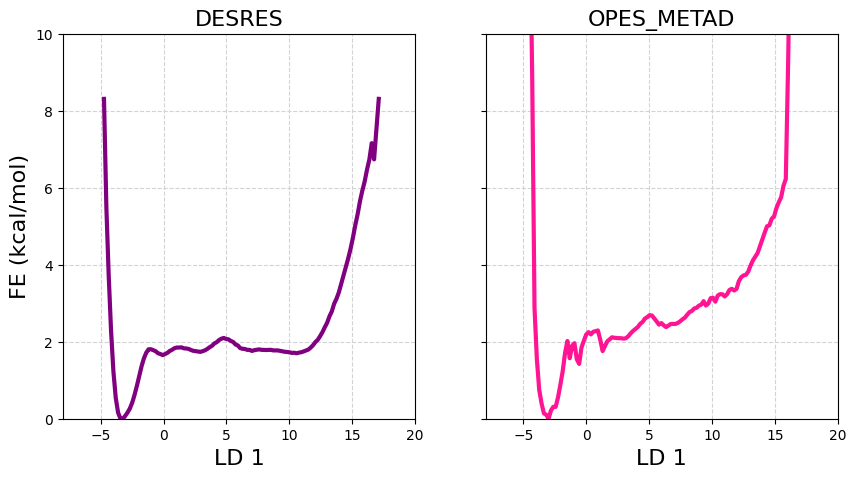

In [38]:
# try the same plot with extended 10us long OPES_METAD data

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10,5), dpi=100)

axs[0].set_xlim(-8,20)
axs[0].set_ylim(0,10)
axs[0].set_xlabel("LD 1", fontsize=16)
axs[0].set_ylabel("FE (kcal/mol)", fontsize=16)
axs[0].set_title("DESRES", fontsize=16)
axs[0].grid(axis="both", which="major", linestyle="--", color="lightgrey")
axs[0].plot(grids, fe-fe.min(), lw=3.0, color="purple")


axs[1].set_xlim(-8,20)
axs[1].set_ylim(0,10)
axs[1].set_xlabel("LD 1", fontsize=16)
axs[1].set_title("OPES_METAD", fontsize=16)
axs[1].grid(axis="both", which="major", linestyle="--", color="lightgrey")


#axs[1].plot(x+proj_fu_avg, fx*(gamma/(gamma-1)), lw=3.0, color="deeppink")  ### need to check the pre factor thing!!
axs[1].plot(x+proj_fu_avg, fx, lw=3.0, color="deeppink")  ### need to check the pre factor thing!!


### let's do cluster prediction on OPES_METAD trajdata

(209368,)


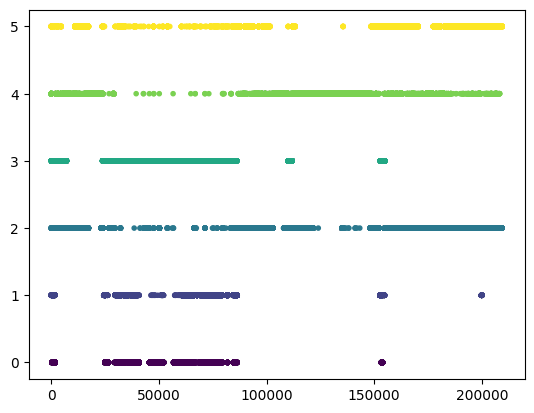

In [39]:
# predcit
clusters_opes_metad,_,_ = wsgmm.predict_weighted(opes_traj[1::,:,:])
print(clusters_opes_metad.shape)


import matplotlib as mpl
#---------------------------------#

bounds = np.arange(7)
cmap = mpl.cm.viridis
#norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plt.scatter(np.arange(len(clusters_opes_metad)), clusters_opes_metad, c=clusters_opes_metad, marker='.', norm=norm)

In [40]:
f_ind = np.array([x[0] for x in np.argwhere(clusters_opes_metad == 0)])
u_ind = np.array([x[0] for x in np.argwhere(clusters_opes_metad == 4)])

print(f_ind.shape)
print(u_ind.shape)

(18297,)
(48553,)


In [41]:
cluster_ids, cluster_populations = np.unique(clusters_opes_metad,return_counts=True)
n_clusters = cluster_ids.size

print("Total no. of clusters =", n_clusters)
print("Cluster ID:", cluster_ids)
print("Populations of clusters:", cluster_populations)

Total no. of clusters = 6
Cluster ID: [0 1 2 3 4 5]
Populations of clusters: [18297 17963 49445 31925 48553 43185]


## Make some plots on 2D RMSD space

## RMSD plots using OPES_METAD data

In [42]:
opes_rmsd_data = np.load("opes_rmsd_data_10us.npy", allow_pickle=True)
print(opes_rmsd_data.shape)

rmsd_h1 = opes_rmsd_data[:,0]
rmsd_h2 = opes_rmsd_data[:,1]
rmsd_h3 = opes_rmsd_data[:,2]

(209368, 3)


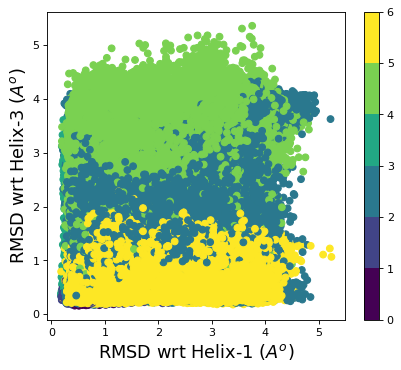

In [43]:
import matplotlib as mpl
#---------------------------------#

bounds = np.arange(7)
cmap = mpl.cm.viridis
#norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(6,5), dpi=80)
plt.xlabel("RMSD wrt Helix-1 ($A^o$)", fontsize=16)
plt.ylabel("RMSD wrt Helix-3 ($A^o$)",fontsize=16)
plt.scatter(rmsd_h1, rmsd_h3, c=clusters_opes_metad, norm=norm)
cbar=plt.colorbar()

In [79]:
print(opes_bias.shape)
print(opes_bias[::50].shape)
print(opes_bias[::50][1:opes_traj.shape[0]:].shape)
print(rmsd_h1.shape)
print(rmsd_h2.shape)
print(opes_traj.shape)

(10474936,)
(209499,)
(209368,)
(209368,)
(209368,)
(209369, 101, 3)


(209368,)


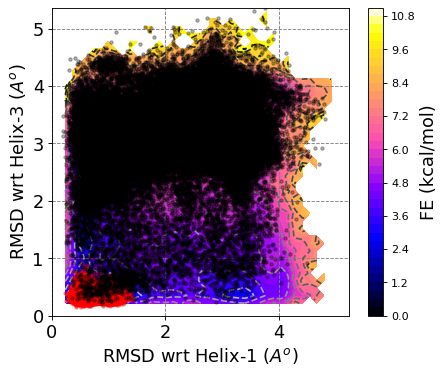

In [84]:
import matplotlib.cm as cm

plt.figure(figsize=(6, 5),dpi=80)
plt.xlabel("RMSD wrt Helix-1 ($A^o$)",fontsize=16)
plt.ylabel("RMSD wrt Helix-3 ($A^o$)",fontsize=16)
plt.xlim(0, max(rmsd_h1))
plt.ylim(0, max(rmsd_h3))
x = rmsd_h1.copy()
y = rmsd_h3.copy()

print(x.shape)

#H, xedges, yedges = np.histogram2d(x,y,bins=40,density=True, weights=np.exp(opes_bias[::50][1::]/kbt))
H, xedges, yedges = np.histogram2d(x,y,bins=40,density=True, weights=np.exp(opes_bias[::50][1:opes_traj.shape[0]:]/kbt))

xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
H = -kbt*np.log(H.T)   # not multiplying here with the prefactor
H -= H.min()
xx, yy = np.meshgrid(xcenters, ycenters)
im = plt.contourf(xx,yy,H,cmap='gnuplot2', levels=40)
plt.contour(xx,yy,H, cmap="binary", levels=15, linestyles="--")

plt.plot(x[f_ind], y[f_ind], '.', color="red", alpha=0.3, label="folded")
plt.plot(x[u_ind], y[u_ind], '.', color="black", alpha=0.3, label="unfolded")
#plt.legend(loc="upper right", fontsize="small")


plt.tick_params(axis='both',labelsize=16)
plt.grid(b=True, which='major', axis='both', color='#808080', linestyle="dashed")
cbar=plt.colorbar(im)
cbar.set_label("FE (kcal/mol)", fontsize=16)

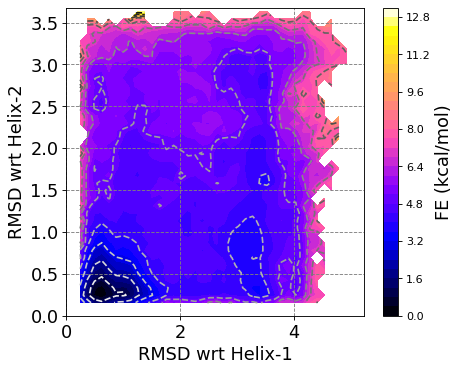

In [85]:
import matplotlib.cm as cm

plt.figure(figsize=(6, 5),dpi=80)
plt.xlabel("RMSD wrt Helix-1",fontsize=16)
plt.ylabel("RMSD wrt Helix-2",fontsize=16)
plt.xlim(0, max(rmsd_h1))
plt.ylim(0, max(rmsd_h2))
x = rmsd_h1.copy()
y = rmsd_h2.copy()

#H, xedges, yedges = np.histogram2d(x,y,bins=40,density=True, weights=np.exp(opes_bias[::50][1::]/kbt))
H, xedges, yedges = np.histogram2d(x,y,bins=40,density=True, weights=np.exp(opes_bias[::50][1:opes_traj.shape[0]:]/kbt))

xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
H = -kbt*np.log(H.T)   # not multiplying here with the prefactor
H -= H.min()
xx, yy = np.meshgrid(xcenters, ycenters)
im = plt.contourf(xx,yy,H,cmap='gnuplot2', levels=40)
plt.contour(xx,yy,H, cmap="binary", levels=15, linestyles="--")
plt.tick_params(axis='both',labelsize=16)
plt.grid(b=True, which='major', axis='both', color='#808080', linestyle="dashed")
cbar=plt.colorbar(im)
cbar.set_label("FE (kcal/mol)", fontsize=16)

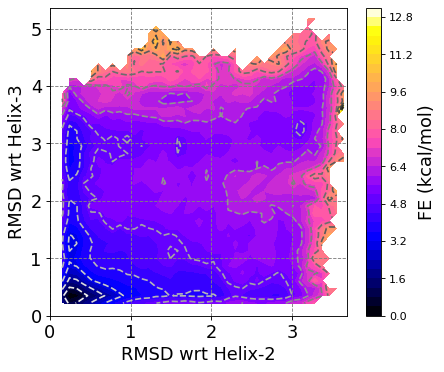

In [86]:
import matplotlib.cm as cm

plt.figure(figsize=(6, 5),dpi=80)
plt.xlabel("RMSD wrt Helix-2",fontsize=16)
plt.ylabel("RMSD wrt Helix-3",fontsize=16)
plt.xlim(0, max(rmsd_h2))
plt.ylim(0, max(rmsd_h3))
x = rmsd_h2.copy()
y = rmsd_h3.copy()

#H, xedges, yedges = np.histogram2d(x,y,bins=40,density=True, weights=np.exp(opes_bias[::50][1::]/kbt))
H, xedges, yedges = np.histogram2d(x,y,bins=40,density=True, weights=np.exp(opes_bias[::50][1:opes_traj.shape[0]:]/kbt))

xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
H = -kbt*np.log(H.T)   # not multiplying here with the prefactor
H -= H.min()
xx, yy = np.meshgrid(xcenters, ycenters)
im = plt.contourf(xx,yy,H,cmap='gnuplot2', levels=40)
plt.contour(xx,yy,H, cmap="binary", levels=15, linestyles="--")
plt.tick_params(axis='both',labelsize=16)
plt.grid(b=True, which='major', axis='both', color='#808080', linestyle="dashed")
cbar=plt.colorbar(im)
cbar.set_label("FE (kcal/mol)", fontsize=16)

## RMSD plots using DESRES data

In [88]:
desres_rmsd_data = np.load("desres_rmsd_data.npy", allow_pickle=True)
print(desres_rmsd_data.shape)

rmsd_h1_desres = desres_rmsd_data[:,0]
rmsd_h2_desres = desres_rmsd_data[:,1]
rmsd_h3_desres = desres_rmsd_data[:,2]

(1526040, 3)


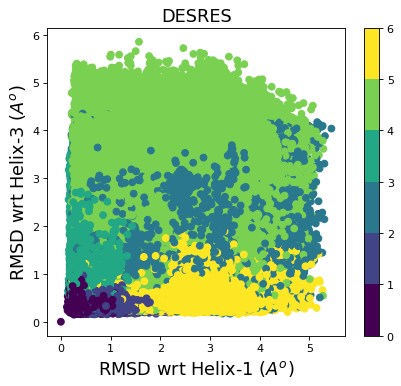

In [89]:
import matplotlib as mpl
#---------------------------------#

bounds = np.arange(7)
cmap = mpl.cm.viridis
#norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(6,5), dpi=80)
plt.title("DESRES", fontsize=16)
plt.xlabel("RMSD wrt Helix-1 ($A^o$)", fontsize=16)
plt.ylabel("RMSD wrt Helix-3 ($A^o$)",fontsize=16)
plt.scatter(rmsd_h1_desres, rmsd_h3_desres, c=clusters[1::], norm=norm)
cbar=plt.colorbar()

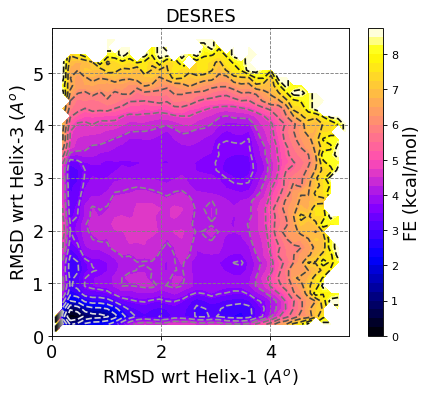

In [90]:
import matplotlib.cm as cm

plt.figure(figsize=(6, 5),dpi=80)
plt.title("DESRES", fontsize=16)
plt.xlabel("RMSD wrt Helix-1 ($A^o$)",fontsize=16)
plt.ylabel("RMSD wrt Helix-3 ($A^o$)",fontsize=16)
plt.xlim(0, max(rmsd_h1_desres))
plt.ylim(0, max(rmsd_h3_desres))
x = rmsd_h1_desres.copy()
y = rmsd_h3_desres.copy()
H, xedges, yedges = np.histogram2d(x,y,bins=40,density=True)
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
H = -kbt*np.log(H.T)   # not multiplying here with the prefactor
H -= H.min()
xx, yy = np.meshgrid(xcenters, ycenters)
im = plt.contourf(xx,yy,H,cmap='gnuplot2', levels=40)
plt.contour(xx,yy,H, cmap="binary", levels=15, linestyles="--")

#plt.plot(x[f_ind], y[f_ind], '.', color="red", alpha=0.3, label="folded")
#plt.plot(x[u_ind], y[u_ind], '.', color="black", alpha=0.3, label="unfolded")
#plt.legend(loc="upper right", fontsize="small")

plt.tick_params(axis='both',labelsize=16)
plt.grid(b=True, which='major', axis='both', color='#808080', linestyle="dashed")
cbar=plt.colorbar(im)
cbar.set_label("FE (kcal/mol)", fontsize=16)

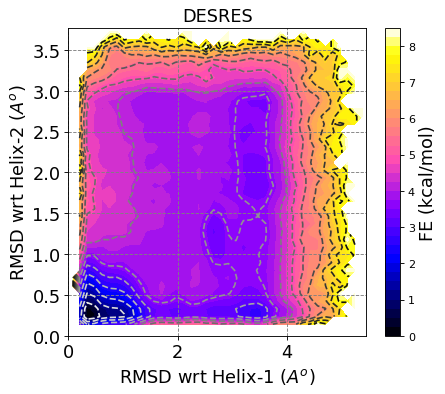

In [91]:
import matplotlib.cm as cm

plt.figure(figsize=(6, 5),dpi=80)
plt.title("DESRES", fontsize=16)
plt.xlabel("RMSD wrt Helix-1 ($A^o$)",fontsize=16)
plt.ylabel("RMSD wrt Helix-2 ($A^o$)",fontsize=16)
plt.xlim(0, max(rmsd_h1_desres))
plt.ylim(0, max(rmsd_h2_desres))
x = rmsd_h1_desres.copy()
y = rmsd_h2_desres.copy()
H, xedges, yedges = np.histogram2d(x,y,bins=40,density=True)
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
H = -kbt*np.log(H.T)   # not multiplying here with the prefactor
H -= H.min()
xx, yy = np.meshgrid(xcenters, ycenters)
im = plt.contourf(xx,yy,H,cmap='gnuplot2', levels=40)
plt.contour(xx,yy,H, cmap="binary", levels=15, linestyles="--")

#plt.plot(x[f_ind], y[f_ind], '.', color="red", alpha=0.3, label="folded")
#plt.plot(x[u_ind], y[u_ind], '.', color="black", alpha=0.3, label="unfolded")
#plt.legend(loc="upper right", fontsize="small")

plt.tick_params(axis='both',labelsize=16)
plt.grid(b=True, which='major', axis='both', color='#808080', linestyle="dashed")
cbar=plt.colorbar(im)
cbar.set_label("FE (kcal/mol)", fontsize=16)

## plot FE vs rmsds sidewise for DESRES and OPES_METAD

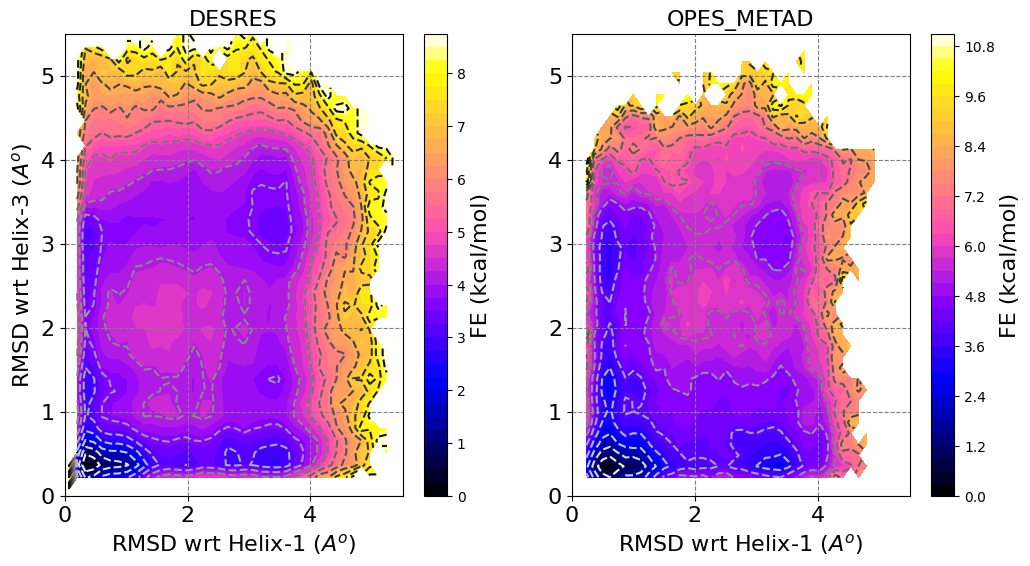

In [92]:
import matplotlib.cm as cm

fig, axs = plt.subplots(1, 2, figsize=(12,6), dpi=100)


# DESRES
axs[0].set_title("DESRES", fontsize=16)
axs[0].set_xlabel("RMSD wrt Helix-1 ($A^o$)",fontsize=16)
axs[0].set_ylabel("RMSD wrt Helix-3 ($A^o$)",fontsize=16)
axs[0].set_xlim(0, 5.5)
axs[0].set_ylim(0, 5.5)
x = rmsd_h1_desres.copy()
y = rmsd_h3_desres.copy()
H, xedges, yedges = np.histogram2d(x,y,bins=40,density=True)
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
H = -kbt*np.log(H.T)   # not multiplying here with the prefactor
H -= H.min()
xx, yy = np.meshgrid(xcenters, ycenters)
im = axs[0].contourf(xx,yy,H,cmap='gnuplot2', levels=40)
axs[0].contour(xx,yy,H, cmap="binary", levels=15, linestyles="--")

axs[0].tick_params(axis='both',labelsize=16)
axs[0].grid(b=True, which='major', axis='both', color='#808080', linestyle="dashed")
cbar=plt.colorbar(im, ax=axs[0])
cbar.set_label("FE (kcal/mol)", fontsize=16)

# OPES_METAD
axs[1].set_title("OPES_METAD", fontsize=16)
axs[1].set_xlabel("RMSD wrt Helix-1 ($A^o$)",fontsize=16)
axs[1].set_xlim(0, 5.5)
axs[1].set_ylim(0, 5.5)
x = rmsd_h1.copy()
y = rmsd_h3.copy()

#H, xedges, yedges = np.histogram2d(x,y,bins=40,density=True, weights=np.exp(opes_bias[::50][1::]/kbt))
H, xedges, yedges = np.histogram2d(x,y,bins=40,density=True, weights=np.exp(opes_bias[::50][1:opes_traj.shape[0]:]/kbt))

xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
H = -kbt*np.log(H.T)   # not multiplying here with the prefactor
H -= H.min()
xx, yy = np.meshgrid(xcenters, ycenters)
im = axs[1].contourf(xx,yy,H,cmap='gnuplot2', levels=40)
axs[1].contour(xx,yy,H, cmap="binary", levels=15, linestyles="--")

axs[1].tick_params(axis='both',labelsize=16)
axs[1].grid(b=True, which='major', axis='both', color='#808080', linestyle="dashed")
cbar=plt.colorbar(im, ax=axs[1])
cbar.set_label("FE (kcal/mol)", fontsize=16)


plt.savefig("fe_vs_rmsds_compare.pdf", format="pdf")

## Make the porcupine script 

In [36]:
# The Topology we made for HP35.
forFile = "/scratch/projects/hockygroup/ss12902/hp35_sGMM/lda_scalings_global_folded_unfolded_ld1.txt"
vmdFile = "vmd_porcupine.tcl"

new_univ = md.Universe("/scratch/projects/hockygroup/ss12902/opes_metad_folded_unfolded_ld1_360K/analysis/npt.gro")
atoms = new_univ.select_atoms(bb_atoms)
print(atoms.indices.shape)
positions = atoms.positions
print(positions.shape)
forces_data = np.loadtxt(forFile)*4.0

vmdOut = open(vmdFile,"w")
for atom in range(positions.shape[0]):
    forces = forces_data[atom*3:atom*3+3:]
    #print(forces.shape)
    #mid = positions[atom,:] + 0.5*forces
    mid = positions[atom,:] + 0.7*forces
    end = positions[atom,:] + forces
    vmdOut.write("draw color yellow\n")
    vmdOut.write("draw cylinder {%10.3f %10.3f %10.3f} {%10.3f %10.3f %10.3f} radius 0.10\n" % (positions[atom,0],positions[atom,1],positions[atom,2],mid[0],mid[1],mid[2]))
    vmdOut.write("draw color red\n")
    vmdOut.write("draw cone {%10.3f %10.3f %10.3f} {%10.3f %10.3f %10.3f} radius 0.20\n" % (mid[0],mid[1],mid[2],end[0],end[1],end[2]))

vmdOut.close()

(101,)
(101, 3)


## get the avg. Free energy from different runs

In [35]:
# load data (Used the same range and nbins as DESRES!)

#xy = np.loadtxt("/scratch/projects/hockygroup/ss12902/opes_metad_folded_unfolded_ld1_360K/analysis/fe_ld1_state.dat", usecols=(0,1))

xy = np.loadtxt("/scratch/projects/hockygroup/ss12902/opes_metad_folded_unfolded_ld1_360K/extended_data_from_glen/analysis/fe_ld1_state.dat", usecols=(0,1))

fe_data = [xy]
for i in range(3):
    xy = np.loadtxt("/scratch/projects/hockygroup/ss12902/opes_metad_folded_unfolded_ld1_360K/run_%d/analysis/fe_ld1_state.dat"%(i+1), usecols=(0,1))
    fe_data.append(xy)
fe_data = np.array(fe_data)
print(fe_data.shape)

(4, 151, 2)


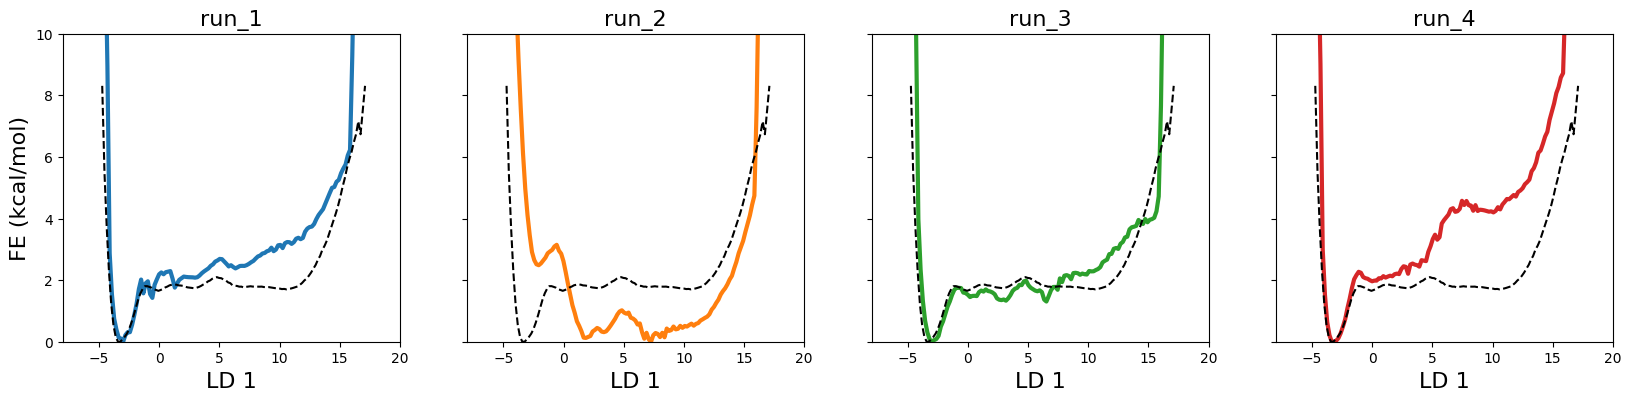

In [36]:
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(20,4), dpi=100)
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

for i in range(4):
    if i==0:
        axs[i].set_ylabel("FE (kcal/mol)", fontsize=16)
    axs[i].set_ylim(0.0, 10.0)
    axs[i].set_xlim(-8.0, 20.0)
    axs[i].set_title("run_%d"%(i+1), fontsize=16)
    axs[i].set_xlabel("LD 1", fontsize=16)
    
    #axs[i].plot(fe_data[i,:,0]*-1+proj_fu_avg, fe_data[i,:,1]*(gamma/(gamma -1))*(1/4.184), lw=3.0, color=colors[i])
    axs[i].plot(fe_data[i,:,0]*-1+proj_fu_avg, fe_data[i,:,1]*(1/4.184), lw=3.0, color=colors[i])


    axs[i].plot(grids_desres, fe_desres, linestyle='--', color="k")

## plot LD1 vs. time for different runs 

In [43]:
ld1_data=[]
ld1_data = [ld1_opes]
for i in range(3):
    l = np.loadtxt("/scratch/projects/hockygroup/ss12902/opes_metad_folded_unfolded_ld1_360K/run_%d/COLVAR"%(i+1), usecols=1)*-1.0
    l += proj_fu_avg
    ld1_data.append(l)
ld1_data = np.array(ld1_data)
print(ld1_data.shape)

(4,)


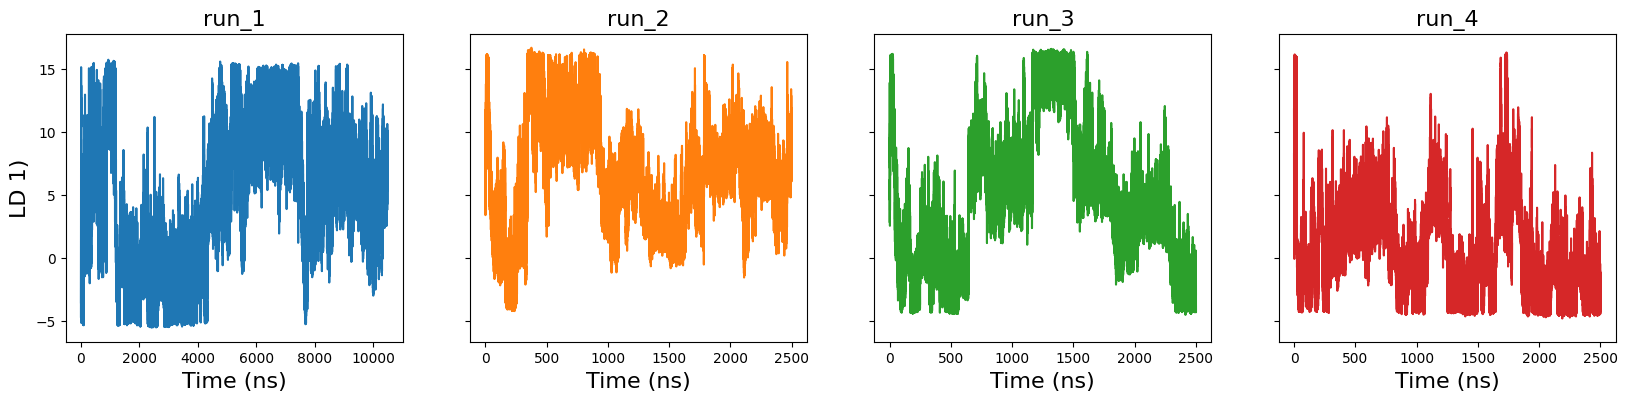

In [53]:
#fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(20,4), dpi=100)
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(20,4), dpi=100)

#time = np.arange(ld1_data.shape[1])*1e-3
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

for i in range(4):
    time = np.arange(ld1_data[i].shape[0])*1e-3
    if i==0:
        axs[i].set_ylabel("LD 1)", fontsize=16)
    #axs[i].set_ylim(0.0, 10.0)
    #axs[i].set_xlim(-8.0, 20.0)
    axs[i].set_title("run_%d"%(i+1), fontsize=16)
    axs[i].set_xlabel("Time (ns)", fontsize=16)
    
    #axs[i].plot(time, ld1_data[i,:], color=colors[i])
    axs[i].plot(time, ld1_data[i], color=colors[i])

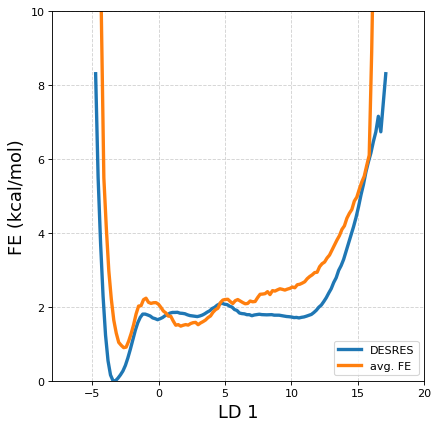

In [37]:
#avg_fe_ = np.mean(fe_data[:,:,1]*(gamma/(gamma-1))*(1/4.184), axis=0)
avg_fe_ = np.mean(fe_data[:,:,1]*(1/4.184), axis=0)

plt.figure(figsize=(6,6), dpi=80)
plt.ylim(0,10)
plt.xlim(-8,20)
plt.xlabel("LD 1", fontsize=16)
plt.ylabel("FE (kcal/mol)", fontsize=16)
plt.grid(axis="both", which="major", linestyle="--", color="lightgrey")
plt.plot(grids_desres, fe_desres, label="DESRES", lw=3.0)
plt.plot((fe_data[0,:,0]*-1)+proj_fu_avg, avg_fe_, label="avg. FE ", lw=3.0)
plt.legend()

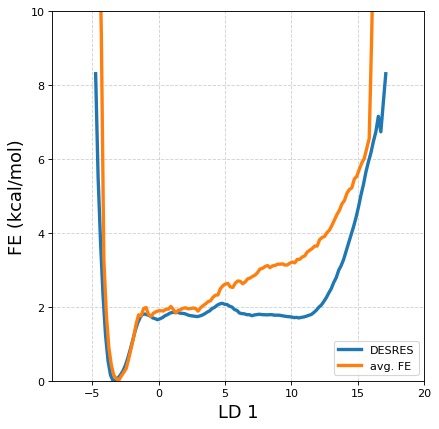

In [38]:
# not considering run_2 (outlier!!)
#avg_fe_ = np.mean(fe_data[(0,2,3),:,1]*(gamma/(gamma-1))*(1/4.184), axis=0)
avg_fe_ = np.mean(fe_data[(0,2,3),:,1]*(1/4.184), axis=0)


plt.figure(figsize=(6,6), dpi=80)
plt.ylim(0,10)
plt.xlim(-8,20)
plt.xlabel("LD 1", fontsize=16)
plt.ylabel("FE (kcal/mol)", fontsize=16)
plt.grid(axis="both", which="major", linestyle="--", color="lightgrey")
plt.plot(grids_desres, fe_desres, label="DESRES", lw=3.0)
plt.plot((fe_data[0,:,0]*-1)+proj_fu_avg, avg_fe_, label="avg. FE ", lw=3.0)
plt.legend()

In [56]:
print(avg_fe_.shape)

(151,)


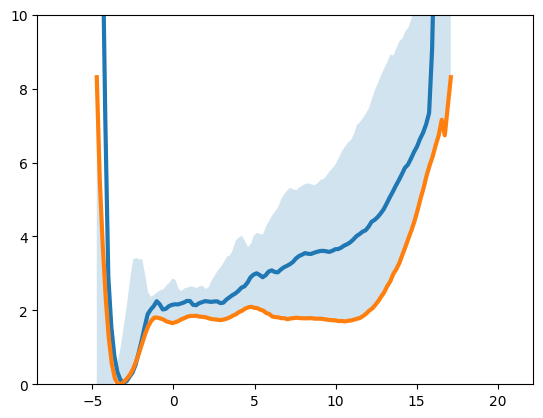

In [57]:
y = (avg_fe_[:-1]+avg_fe_[1:])/2.0
yerr = np.abs(y[::-1]-fe_desres)
plt.plot(grids_desres+proj_fu_avg, y[::-1], lw=3.0)
plt.plot(grids_desres, fe_desres, lw=3.0)
plt.ylim(0, 10.0)
plt.fill_between(grids_desres, y[::-1]-yerr, y[::-1]+yerr, alpha=0.2)

In [58]:
print(fe_data[3,:,0]*-1)

[20.       19.813333 19.626667 19.44     19.253333 19.066667 18.88
 18.693333 18.506667 18.32     18.133333 17.946667 17.76     17.573333
 17.386667 17.2      17.013333 16.826667 16.64     16.453333 16.266667
 16.08     15.893333 15.706667 15.52     15.333333 15.146667 14.96
 14.773333 14.586667 14.4      14.213333 14.026667 13.84     13.653333
 13.466667 13.28     13.093333 12.906667 12.72     12.533333 12.346667
 12.16     11.973333 11.786667 11.6      11.413333 11.226667 11.04
 10.853333 10.666667 10.48     10.293333 10.106667  9.92      9.733333
  9.546667  9.36      9.173333  8.986667  8.8       8.613333  8.426667
  8.24      8.053333  7.866667  7.68      7.493333  7.306667  7.12
  6.933333  6.746667  6.56      6.373333  6.186667  6.        5.813333
  5.626667  5.44      5.253333  5.066667  4.88      4.693333  4.506667
  4.32      4.133333  3.946667  3.76      3.573333  3.386667  3.2
  3.013333  2.826667  2.64      2.453333  2.266667  2.08      1.893333
  1.706667  1.52      1.333

# FE estimation using Block Averaging

## write code for TCF

In [57]:
taus = np.linspace(1000, 30000, 30, endpoint=True, dtype=int)
print(taus)

n_frames = trajData.shape[0]
print(n_frames)

[ 1000  2000  3000  4000  5000  6000  7000  8000  9000 10000 11000 12000
 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000
 25000 26000 27000 28000 29000 30000]
1526041


In [58]:
x = ld1_fu - np.mean(ld1_fu)

In [59]:
correl_data = []
for tau in taus:
    correl = 0.0
    for i in range(n_frames-tau):
        correl += (ld1_fu[i]*ld1_fu[i+tau])
        #correl += (x[i]*x[i+tau])
    correl /= (n_frames-tau)
    correl_data.append(correl)

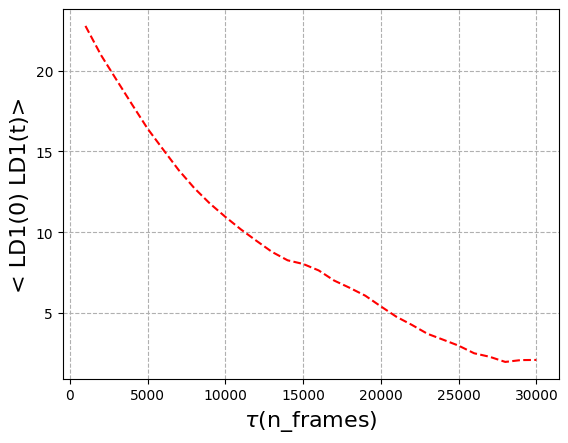

In [60]:
plt.ylabel("< LD1(0) LD1(t)>", fontsize=16)
plt.xlabel("$\\tau$(n_frames)", fontsize=16)
plt.plot(taus, correl_data, '--', color="red")
plt.grid(linestyle="--")

In [61]:
print(correl_data)

[22.765602540287563, 20.96073977413597, 19.42544381805335, 17.901771496897325, 16.40479813533903, 15.115464221979257, 13.841345271514406, 12.732575759257017, 11.779834759904269, 10.95166796758897, 10.174650067336863, 9.468739194170666, 8.783379352071002, 8.265005226325812, 8.038874950415268, 7.638958913403976, 7.009600098289841, 6.559868850381805, 6.0745319593490565, 5.413071899918093, 4.771646125864954, 4.265463331534518, 3.716806037316168, 3.3543622422745925, 2.98432964586844, 2.5124935857668906, 2.29506741426599, 1.9777221678078987, 2.091213978036447, 2.10080557757578]


In [62]:
b_s = 12000
n_b = int(trajData.shape[0]/b_s)
print(b_s, n_b)

ld_range=(-8,20)
nbins=150


all_fe_data = []

for i in range(n_b):
    if i != n_b-1:
        x = ld1_fu[i*b_s:(i+1)*b_s:1]
    else:
        x = ld1_fu[i*b_s::1]
        
    # histogram 
    h, _ = np.histogram(x, range=ld_range, bins=nbins, density=True)
    #f = -kbt*np.log(h)
    #f -= f.min()
    #all_fe_data.append(f)
    all_fe_data.append(h)

all_fe_data = np.array(all_fe_data)
print(all_fe_data.shape)

12000 127
(127, 150)


(150,)
(150,)


<ErrorbarContainer object of 3 artists>

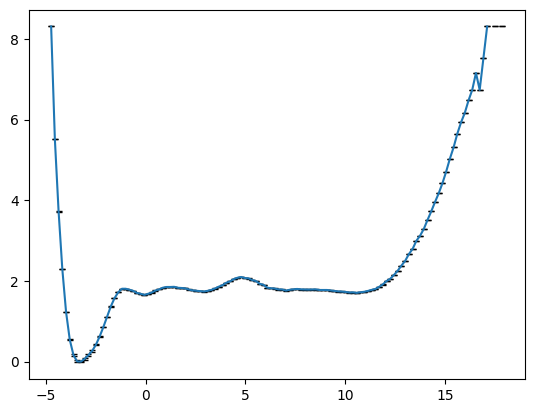

In [63]:
real_std_list = np.std(all_fe_data, axis=0)/np.sqrt(n_b-1)  #!! please check this, denominator shoudl be there.
#real_std_list = np.std(all_fe_data, axis=0)
real_min_list = np.mean(all_fe_data, axis=0)
print(real_min_list.shape)
print(real_std_list.shape)

fes = -kbt*np.log(real_min_list)
fes -= fes.min()

plt.errorbar(grids, fes, real_std_list, fmt="-", capsize=2.0, ecolor="k", elinewidth=0.5)

In [64]:
print(real_std_list)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.51518560e-06 2.64470408e-05 1.94383066e-04
 1.23695050e-03 5.29396054e-03 1.32222602e-02 2.12094399e-02
 2.40092204e-02 2.19632490e-02 1.89981598e-02 1.72000389e-02
 1.57198865e-02 1.31547673e-02 1.00743470e-02 7.17285234e-03
 4.95774651e-03 3.36330436e-03 2.44367213e-03 1.87100901e-03
 1.60359937e-03 1.63051703e-03 1.68792135e-03 1.91919410e-03
 2.16969758e-03 2.27504607e-03 2.50385265e-03 2.44505395e-03
 2.23710395e-03 2.09103353e-03 1.95921857e-03 1.86204179e-03
 1.89230223e-03 1.83759353e-03 1.88250422e-03 1.92030359e-03
 1.93148018e-03 1.92395574e-03 2.10674875e-03 2.14586824e-03
 2.19607463e-03 2.36766736e-03 2.55604570e-03 2.62235432e-03
 2.76195115e-03 2.71825812e-03 2.75513914e-03 2.67941608e-03
 2.50883871e-03 2.518550

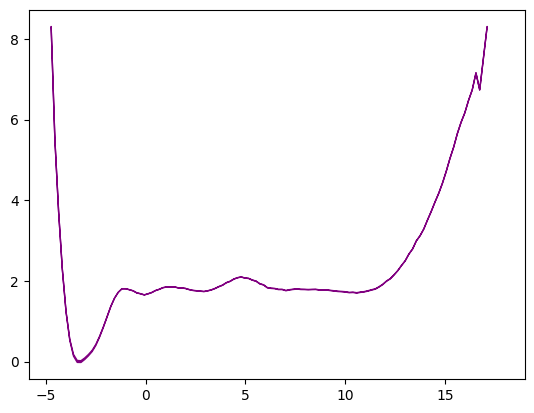

In [65]:
plt.fill_between(grids, fes-real_std_list, fes+real_std_list, color="purple")

## OPES_METAD 2.5us histogram of LD1 for difft clusters

In [66]:
clusters_opes, _, _= wsgmm.predict_weighted(opes_traj)
print(clusters_opes.shape)

(50001,)


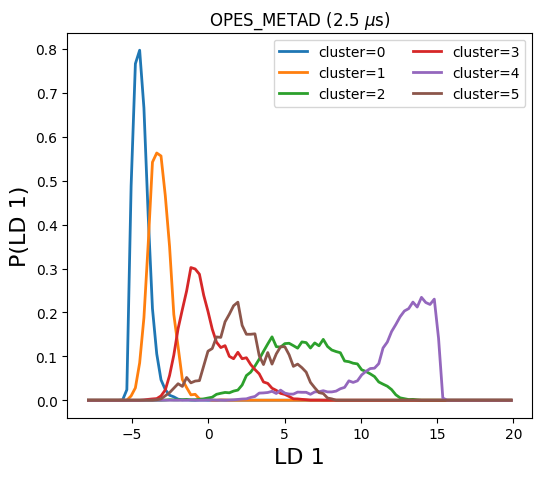

In [67]:
ld_range=[-8,20]
nbins=100
y = ld1_opes[::50]


plt.figure(figsize=(6,5), dpi=100)
plt.title("OPES_METAD (2.5 $\\mu$s)")
plt.xlabel("LD 1", fontsize=16)
plt.ylabel("P(LD 1)", fontsize=16)
# looping over clusters
for i in range(wsgmm.n_clusters):
    
    # extracting LD values corresponding to each state
    ld_i = y[[x[0] for x in np.argwhere(clusters_opes == i)]]
    
    # histogramming
    hist_i ,bins = np.histogram(ld_i, range=ld_range, bins=nbins, density=True)
    grids = (bins[1:] + bins[:-1])/2.0
    
    # calculate the weights
    #weight = np.argwhere(clusters==i).size/clusters.size
    
    #plot it
    #plt.plot(grids, hist_i*weight, label="cluster=%d"%i, lw=2.0)
    plt.plot(grids, hist_i, label="cluster=%d"%i, lw=2.0)    
    #plt.fill_between(grids, hist_i)
    
plt.legend(loc="upper right", ncol=2, fontsize="medium", markerscale=2.0)